In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime


# Result of the Rule Based Detection (main.py):
Number of **Complete** Cases: 

Number of **Finished** Cases: 

Number of **Unfinished** Cases:

Number of **Expired** Cases: 

Number of **Expired** or **Unfinished** Cases: 

Number of **Finished Complete** Cases: 

In [4]:
hospital_billing = pd.read_csv('../Dataset/csv/Hospital Billing - Event Log.csv', keep_default_na=False, na_values=['NaN', "", " "])
print(hospital_billing.columns)
print(f"Length before removing NaN: {len(hospital_billing)}")
hospital_billing_cleaned = hospital_billing.dropna(subset=['case', 'event', 'state'])
print(f"Length after removing NaN: {len(hospital_billing)}")

Index(['case', 'event', 'startTime', 'completeTime', 'isCancelled', 'msgType',
       'diagnosis', 'version', 'caseType', 'actRed', 'speciality',
       'org:resource', 'closeCode', 'blocked', 'isClosed', 'flagD',
       'actOrange', 'flagC', 'flagB', 'flagA', 'msgCount', 'state', 'msgCode'],
      dtype='object')
Length before removing NaN: 451359
Length after removing NaN: 451359


In [ ]:
hospital_billing[hospital_billing['case'] == "NA"]

In [ ]:
hospital_billing[hospital_billing['case'] == "NAN"]


In [ ]:
print(len(hospital_billing['event'].unique()))
hospital_billing['event'].unique()

In [ ]:
hospital_billing['state'].unique()

In [ ]:
hospital_billing['completeTime'] = pd.to_datetime(hospital_billing['completeTime'])

print(f"The number of activities in the event log: {len(hospital_billing)}")
print(f"The number of distinct cases: {len(hospital_billing.groupby('case'))}")
print(f"The timeframe: {hospital_billing.loc[0,'completeTime']} - {hospital_billing.loc[len(hospital_billing)-1,'completeTime']}")
timeframe = (hospital_billing.loc[len(hospital_billing)-1,'completeTime'] - hospital_billing.loc[0,'completeTime'])
print(f"The timeframe is approximately {timeframe.days//365} years and {(timeframe.days % 365) //30} months.")


## Delta T of Activities

In [ ]:
hospital_billing["delta_t"] = hospital_billing.groupby('case')["completeTime"].diff()
delta_t_mean = hospital_billing.groupby('case')['delta_t'].mean()
hospital_billing[["case","event", "delta_t"]]
delta_t_mean

### How much time has passed before an event?

In [ ]:
time_passed_after_event = hospital_billing.groupby('event')['delta_t'].describe()
time_passed_after_event

# What is the wait period after the events?

In [27]:
# print(hospital_billing.groupby('case')["completeTime"].shift(-1))
# print(hospital_billing["completeTime"])
hospital_billing["wait_period"] = hospital_billing.groupby('case')["completeTime"].shift(-1) - hospital_billing["completeTime"]
wait_period_event_stat = hospital_billing.groupby('event')['wait_period'].describe()
wait_period_event_stat
hospital_billing["wait_period"]

0        363 days 23:27:27
1          0 days 08:53:01
2          1 days 09:02:51
3          1 days 14:48:02
4                      NaT
                ...       
416370     9 days 21:56:28
416371     8 days 05:41:53
416372     0 days 00:53:23
416373     5 days 16:01:50
416374                 NaT
Name: wait_period, Length: 451359, dtype: timedelta64[ns]

451359
351359
99th Percentile: 366.00 days


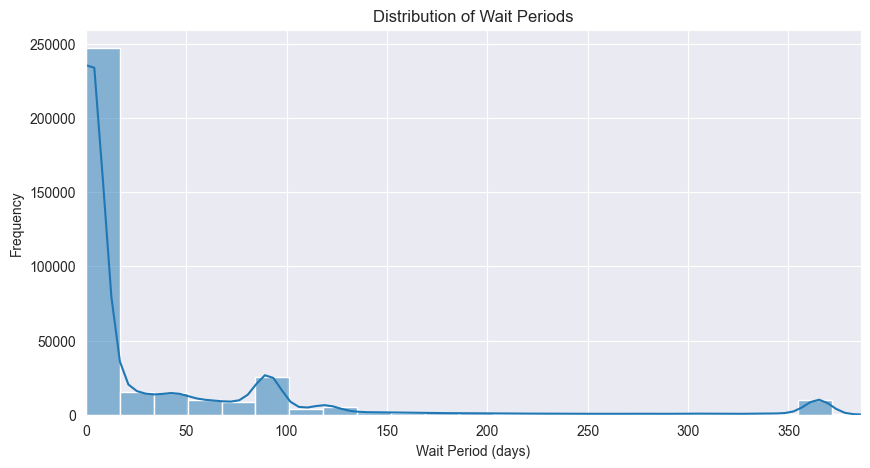

Skewness of the wait period distribution: 3.2511
count    351359.000000
mean         36.248323
std          77.994682
min           0.000000
25%           0.239323
50%           4.022650
75%          35.139329
max         845.201042
Name: wait_period_days, dtype: float64
95th Percentile Upper Limit: 189.39 days
Upper Limit based on IQR (1.5*IQR above Q3): 87.49 days


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew


hospital_billing['wait_period_days'] = hospital_billing['wait_period'].dt.total_seconds() / (3600 * 24)  # Convert to days
print(len(hospital_billing))
wait_period_clean = hospital_billing['wait_period_days'].dropna()
print(len(wait_period_clean))


percentile_99 = np.percentile(wait_period_clean, 99)
print(f"99th Percentile: {percentile_99:.2f} days")

plt.figure(figsize=(10, 5))
sns.histplot(wait_period_clean, bins=50, kde=True)
plt.xlim(0,percentile_99+20)
plt.title('Distribution of Wait Periods')
plt.xlabel('Wait Period (days)')
plt.ylabel('Frequency')
plt.show()


wait_period_skewness = skew(wait_period_clean)
print(f"Skewness of the wait period distribution: {wait_period_skewness:.4f}")


wait_period_stats = wait_period_clean.describe()
print(wait_period_stats)

percentile_95 = np.percentile(wait_period_clean, 95)

IQR = wait_period_stats['75%'] - wait_period_stats['25%']
upper_limit_IQR = wait_period_stats['75%'] + 1.5 * IQR

print(f"95th Percentile Upper Limit: {percentile_95:.2f} days")
print(f"Upper Limit based on IQR (1.5*IQR above Q3): {upper_limit_IQR:.2f} days")


## Distibution of Event Types

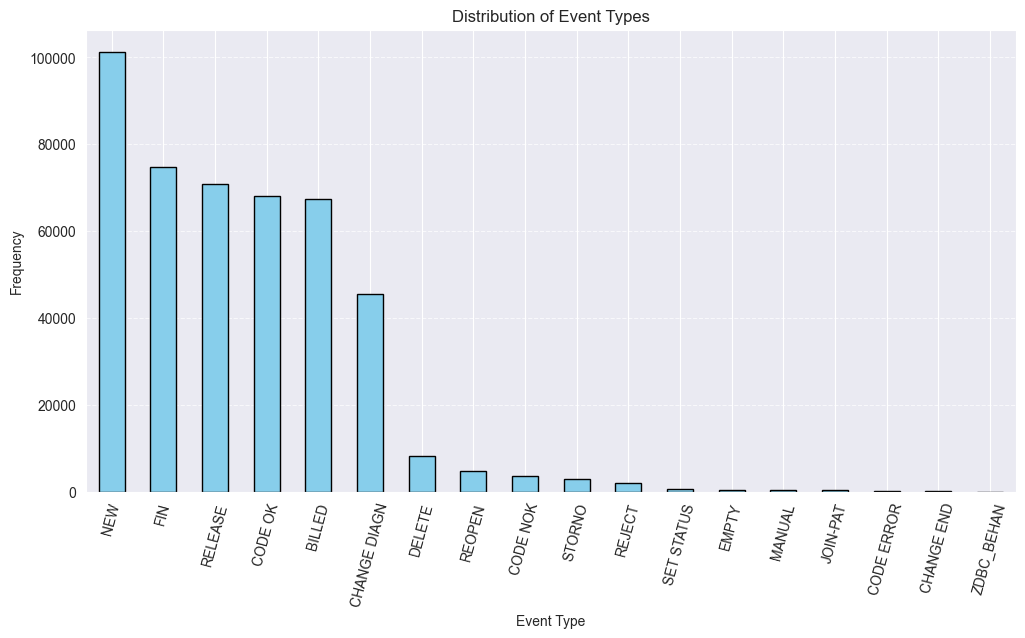

In [16]:
event_counts = hospital_billing['event'].value_counts()

# Plotting the distribution of event types
plt.figure(figsize=(12, 6))
event_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Event Types')
plt.xlabel('Event Type')
plt.ylabel('Frequency')
plt.xticks(rotation=75)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Lengths of Process (#Events)

In [7]:
event_counts = hospital_billing.groupby('case').agg({'event':'count'}).rename(columns={'event': 'event_count'})

low_length_cases = event_counts[event_counts['event_count'] ==2 ].reset_index()['case']
low_length_events = hospital_billing[hospital_billing['case'].isin(low_length_cases)]
hospital_billing = hospital_billing.merge(event_counts, on='case', how='left')
low_length_events

,case,event,startTime,completeTime,isCancelled,msgType,diagnosis,version,caseType,actRed,...,blocked,isClosed,flagD,actOrange,flagC,flagB,flagA,msgCount,state,msgCode
5,B,NEW,2012/12/16 19:33:50.000,2012/12/16 19:33:50.000,False,NaN,B,NaN,A,NaN,...,False,False,False,NaN,NaN,False,False,NaN,In progress,NaN
6,B,DELETE,2013/10/19 12:37:05.000,2013/10/19 12:37:05.000,True,NaN,B,NaN,A,NaN,...,False,False,False,NaN,NaN,False,False,NaN,In progress,NaN
65,L,NEW,2012/12/23 10:33:42.000,2012/12/23 10:33:42.000,False,NaN,NaN,NaN,B,NaN,...,False,False,False,NaN,NaN,False,False,NaN,In progress,NaN
66,L,DELETE,2012/12/23 10:34:04.000,2012/12/23 10:34:04.000,True,NaN,NaN,NaN,B,NaN,...,False,False,False,NaN,NaN,False,False,NaN,In progress,NaN
199,KA,NEW,2013/01/18 19:30:30.000,2013/01/18 19:30:30.000,False,NaN,NaN,NaN,B,NaN,...,False,False,False,NaN,NaN,False,False,NaN,In progress,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451348,VWQE,DELETE,2016/01/12 10:21:42.000,2016/01/12 10:21:42.000,True,NaN,NaN,NaN,B,NaN,...,False,False,False,NaN,NaN,False,False,NaN,In progress,NaN
451349,WWQE,NEW,2015/12/23 11:07:30.000,2015/12/23 11:07:30.000,False,NaN,KD,NaN,A,NaN,...,False,True,True,NaN,NaN,False,False,NaN,In progress,NaN
451350,WWQE,FIN,2015/12/23 11:07:59.000,2015/12/23 11:07:59.000,False,NaN,KD,NaN,A,NaN,...,False,True,True,NaN,NaN,False,False,NaN,Empty,NaN
451355,BXQE,NEW,2016/01/14 21:17:47.000,2016/01/14 21:17:47.000,False,NaN,NaN,NaN,B,NaN,...,False,False,False,NaN,NaN,False,False,NaN,In progress,NaN


In [ ]:
case_counts_by_event = event_counts.reset_index().groupby('event_count').agg({'case':'count'})
case_counts_by_event

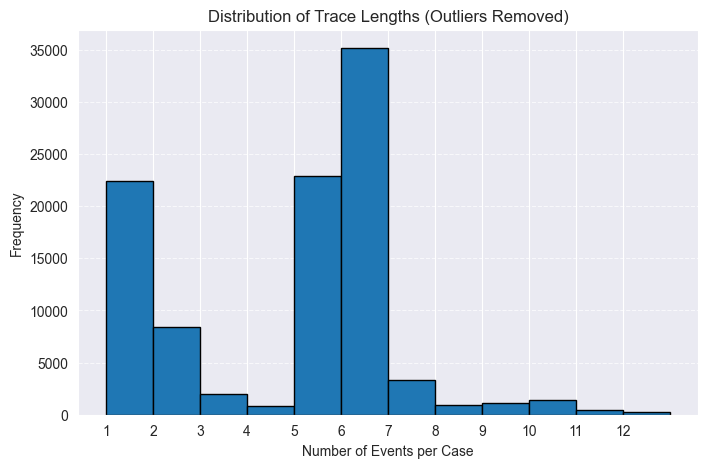

In [8]:
Q1 = event_counts['event_count'].quantile(0.25)
Q3 = event_counts['event_count'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_case_counts = event_counts[(event_counts['event_count'] >= lower_bound) & (event_counts['event_count'] <= upper_bound)]

plt.figure(figsize=(8, 5))
plt.hist(filtered_case_counts['event_count'], bins=range(1, filtered_case_counts['event_count'].max() + 2), edgecolor='black')
plt.xlabel('Number of Events per Case')
plt.ylabel('Frequency')
plt.title('Distribution of Trace Lengths (Outliers Removed)')
plt.xticks(range(1, filtered_case_counts['event_count'].max() + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [10]:
hospital_billing['completeTime'] = pd.to_datetime(hospital_billing['completeTime'])

# Sort by case and completeTime to ensure the last event is correctly identified
hospital_billing = hospital_billing.sort_values(by=['case', 'completeTime'])

# Group by 'case' and get the last event in each group

grouped_hospital = hospital_billing.groupby('case').last().reset_index().rename(columns={'event': 'last_event'})
print(f'Number of cases: {len(grouped_hospital)}')
grouped_hospital.head(25)

Number of cases: 100000


,case,last_event,startTime,completeTime,isCancelled,msgType,diagnosis,version,caseType,actRed,...,isClosed,flagD,actOrange,flagC,flagB,flagA,msgCount,state,msgCode,event_count
0,A,BILLED,2013/12/19 03:44:31.000,2013-12-19 03:44:31,False,None,A,A,A,False,...,True,True,False,False,False,False,0.0,Billed,None,5
1,AA,BILLED,2013/07/07 19:21:27.000,2013-07-07 19:21:27,False,None,CA,C,B,False,...,True,True,False,False,False,False,0.0,Billed,None,6
2,AAA,NEW,2013/01/26 22:56:11.000,2013-01-26 22:56:11,False,None,None,None,C,None,...,True,False,None,None,False,False,NaN,In progress,None,1
3,AAAA,BILLED,2013/10/24 04:16:56.000,2013-10-24 04:16:56,False,None,JA,D,B,False,...,True,True,False,False,False,False,0.0,Billed,None,6
4,AAAB,BILLED,2014/03/16 22:08:48.000,2014-03-16 22:08:48,False,None,Z,A,B,False,...,True,True,False,False,False,False,0.0,Billed,None,6
5,AAAC,BILLED,2014/10/08 11:18:43.000,2014-10-08 11:18:43,False,None,OB,F,B,False,...,True,True,False,False,False,False,0.0,Billed,None,6
6,AAAD,NEW,2014/12/10 22:49:28.000,2014-12-10 22:49:28,False,None,None,None,I,None,...,True,False,None,None,False,False,NaN,In progress,None,1
7,AAAE,FIN,2015/12/01 20:06:35.000,2015-12-01 20:06:35,False,None,T,None,A,None,...,True,True,None,None,False,False,NaN,Empty,None,2
8,AAB,NEW,2013/01/03 22:55:39.000,2013-01-03 22:55:39,False,None,None,None,C,None,...,True,False,None,None,False,False,NaN,In progress,None,1
9,AABA,BILLED,2013/10/31 11:30:59.000,2013-10-31 11:30:59,False,None,AI,D,B,False,...,True,True,False,False,False,False,0.0,Billed,None,6


In [ ]:
grouped_hospital[grouped_hospital['state'] == "Unbillable"].value_counts("last_event")

### Case Durations

Number of cases that are finished as soon as started: 22373
The cases: 
2         AAA
6        AAAD
8         AAB
10       AABB
19       AACE
         ... 
99977    ZZVB
99978    ZZVC
99992    ZZYB
99993    ZZYC
99998    ZZZC
Name: case, Length: 22373, dtype: object


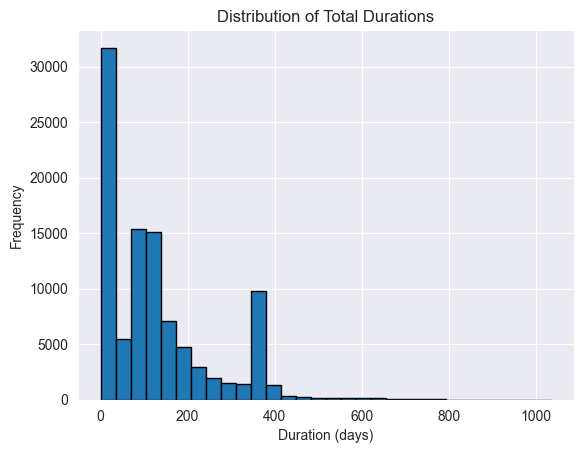

In [11]:
grouped_hospital['trace_start'] = hospital_billing.groupby('case').first().reset_index()['completeTime']
grouped_hospital['trace_end'] = hospital_billing.groupby('case').last().reset_index()['completeTime']
grouped_hospital['trace_duration'] = grouped_hospital['trace_end'] - grouped_hospital['trace_start']

zeroD_zeroH = grouped_hospital[grouped_hospital['trace_duration'] == pd.Timedelta('0 days 00:00:00')]
print(f"Number of cases that are finished as soon as started: {len(zeroD_zeroH)}\nThe cases: \n{zeroD_zeroH['case']}")


durations = grouped_hospital['trace_duration']
durations_in_days = durations.dt.total_seconds() / (24 * 3600)  # Convert to days

# Plot a histogram
plt.hist(durations_in_days, bins=30, edgecolor='black')
plt.title('Distribution of Total Durations')
plt.xlabel('Duration (days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The mean duration: 127 days 08:40:54.860510 
The median duration: 102 days 08:41:21.500000
lower & upper bound: 0 days 00:00:00 & 431 days 02:04:47.375000

After the outliers removed:
The mean duration: 120 days 23:43:09.067815520 
The median duration: 101 days 22:51:41


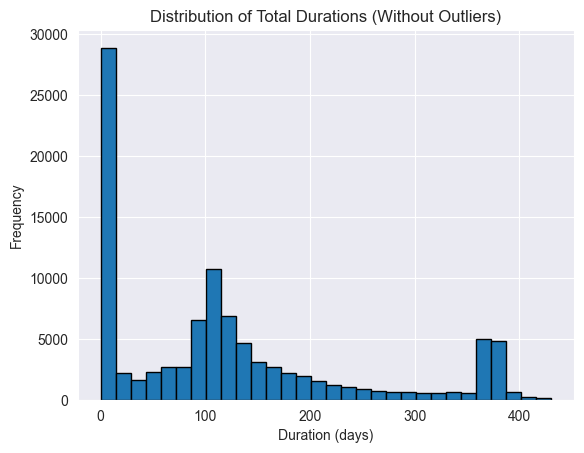

In [12]:
durations = grouped_hospital['trace_duration']
print(f'The mean duration: {durations.mean()} \nThe median duration: {durations.median()}')

Q1 = durations.quantile(0.25)
Q3 = durations.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

if lower_bound<pd.Timedelta('0 days 00:00:00'): lower_bound = pd.Timedelta('0 days 00:00:00')
print(f"lower & upper bound: {lower_bound} & {upper_bound}")

filtered_durations = grouped_hospital[(durations >= lower_bound) & (durations <= upper_bound)]
durations = filtered_durations['trace_duration']
print(f'\nAfter the outliers removed:\nThe mean duration: {durations.mean()} \nThe median duration: {durations.median()}')


durations_in_days = durations.dt.total_seconds() / (24 * 3600)  # Convert to days

# Plot a histogram
plt.hist(durations_in_days, bins=30, edgecolor='black')
plt.title('Distribution of Total Durations (Without Outliers)')
plt.xlabel('Duration (days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The mean duration: 164 days 01:02:19.713403056 
The median duration: 123 days 02:14:27.500000


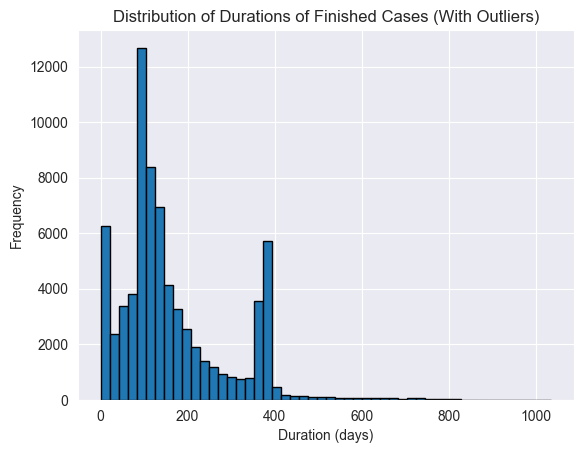

lower & upper bound: 0 days 00:00:00 & 392 days 16:59:10.125000

After the outliers removed:
The mean duration: 154 days 09:29:59.997031426 
The median duration: 120 days 15:34:49


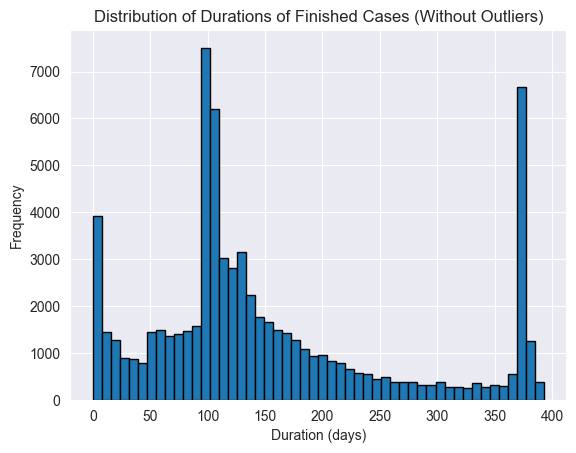

,case,trace_duration,last_event
0,A,367 days 08:11:21,BILLED
1,AA,193 days 10:31:09,BILLED
3,AAAA,127 days 07:50:24,BILLED
4,AAAB,103 days 15:36:40,BILLED
5,AAAC,99 days 19:53:40,BILLED
...,...,...,...
99994,ZZYD,100 days 04:17:24,BILLED
99995,ZZZ,127 days 07:50:43,BILLED
99996,ZZZA,0 days 03:35:15,DELETE
99997,ZZZB,0 days 00:00:40,DELETE


In [13]:
finished_cases = grouped_hospital[(grouped_hospital['state'] == "Billed") | (grouped_hospital['state'] == "Closed") |
                                (grouped_hospital['state'] == "Rejected") | (grouped_hospital['isCancelled'] == True)]

durations = finished_cases['trace_duration']
print(f'The mean duration: {durations.mean()} \nThe median duration: {durations.median()}')

durations_in_days = durations.dt.total_seconds() / (24 * 3600)  # Convert to days
# Plot a histogram
plt.hist(durations_in_days, bins=50, edgecolor='black')
plt.title('Distribution of Durations of Finished Cases (With Outliers)')
plt.xlabel('Duration (days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()




Q1 = durations.quantile(0.25)
Q3 = durations.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

if lower_bound<pd.Timedelta('0 days 00:00:00'): lower_bound = pd.Timedelta('0 days 00:00:00')
print(f"lower & upper bound: {lower_bound} & {upper_bound}")

# Filter the finished cases
filtered_durations = finished_cases[(durations >= lower_bound) & (durations <= upper_bound)]

# Extract trace durations without outliers
no_outlier_durations = filtered_durations['trace_duration']

# Print mean and median after removing outliers
print(f'\nAfter the outliers removed:\nThe mean duration: {no_outlier_durations.mean()} \nThe median duration: {no_outlier_durations.median()}')

# Convert durations to days
durations_in_days = no_outlier_durations.dt.total_seconds() / (24 * 3600)

# Plot histogram of durations without outliers
plt.hist(durations_in_days, bins=50, edgecolor='black')
plt.title('Distribution of Durations of Finished Cases (Without Outliers)')
plt.xlabel('Duration (days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Display filtered cases
filtered_durations[["case", "trace_duration", "last_event"]]


In [ ]:
from datetime import timedelta

# Identify cases with trace duration exceeding the upper bound or median

zeroD_zeroH['time_since_trace_start'] = (
    zeroD_zeroH['completeTime'].max() - zeroD_zeroH['trace_start']
)

# Filter cases where the time since trace_start exceeds the upper bound
unfinished_cases = zeroD_zeroH[
    (zeroD_zeroH['time_since_trace_start'] > upper_bound) &
    (zeroD_zeroH['trace_duration'] == timedelta(0))
]
print(f"Number of unfinished (leftover) cases: {len(unfinished_cases)}")
unfinished_cases[['case', "trace_duration", "time_since_trace_start"]]

There are 12808 cases that did not have follow up events after the first "New" event. It has been more than the 431 days (upper bound for outliers) since the start of the event till the last event shown in the dataset. 

In [ ]:
ongoing_zeroD_zeroH = zeroD_zeroH[
    ~zeroD_zeroH['case'].isin(unfinished_cases['case'])
]

# Display the filtered DataFrame
print(f"Number of completed cases in 0 days: {len(ongoing_zeroD_zeroH)}")
ongoing_zeroD_zeroH[['case', "trace_duration", "time_since_trace_start"]]


### isCancelled 

In [ ]:
not_cancelled = grouped_hospital[grouped_hospital['isCancelled'] !=True]
print('Number of cases that are not cancelled: ', len(not_cancelled))
# print(not_cancelled.head())

cancelled_and_notDelete = grouped_hospital[(grouped_hospital['isCancelled']) & (grouped_hospital['last_event'] != 'DELETE')]
print('\nNumber of cases that are Cancelled but the last event is not DELETE: ',len(cancelled_and_notDelete))#, '\nhead of the table:')
# print(cancelled_and_notDelete)


notCancelled_delete = grouped_hospital[(grouped_hospital['isCancelled'] != True) & (grouped_hospital['last_event'] == 'DELETE')]
print('\nNumber of cases that are not Cancelled and the last event is DELETE: ', len(notCancelled_delete))
# print(notCancelled_delete.head())

cancelled_and_Delete = grouped_hospital[(grouped_hospital['isCancelled']) & (grouped_hospital['last_event'] == 'DELETE')]
print('\nNumber of cases that are Cancelled and the last event is DELETE: ', len(cancelled_and_Delete), '\nhead of the table:')
cancelled_and_Delete[cancelled_and_Delete["event_count"] > 2][['case', "event_count"]]

grouped_hospital[grouped_hospital['isCancelled']]["state"].value_counts()

### Blocked

In [ ]:
blocked = grouped_hospital[grouped_hospital['blocked']]
blocked[['case', 'last_event', 'isCancelled', 'diagnosis', 'version', 'caseType', 'blocked', 'state']]

### actOrange

In [ ]:
actOrange = grouped_hospital[grouped_hospital.fillna(False)['actOrange']]
print(actOrange.groupby('state').agg({'case': 'count'}))
grouped_hospital

### Close Codes:

In [ ]:
# Group by last event's  'closeCode', 'last_event', 'state' and get total number of cases for each combination of these.
close_codes =  grouped_hospital.groupby(['closeCode', 'last_event', 'state']).agg('count').reset_index().sort_values(by='case', ascending=False)
sum_cases = close_codes['case'].sum()
print(f'\nTotal Number of cases in close_codes: {sum_cases}\nclose_codes')
close_codes


## isClosed

In [ ]:
closed = hospital_billing[hospital_billing['isClosed'] == True][["case", "event", "isClosed", "isCancelled","state"]]
not_closed = hospital_billing[hospital_billing['isClosed'] == False][["case", "event", "isClosed", "isCancelled","state"]]
closed

Closed = False --> Deleted (Closed is only True or only False for all events in the case)
       = True --> Process is finished
	Therefore if a case is closed(True) and there has been some time since that event, then it is probably finished incomplete
 
Cancelled: True --> only True on Delete event (last event)


# Last Event and State:

In [17]:
last_event_state_grouped = grouped_hospital.groupby(['last_event','state']).agg({'case': 'count'}).reset_index().sort_values(by='case', ascending=False)
sum_cases = last_event_state_grouped['case'].sum()
last_event_state_grouped['ratio'] = last_event_state_grouped['case']/sum_cases
print(f'\nTotal Number of cases in last_event_state_grouped: {sum_cases}\n:')
last_event_state_grouped


Total Number of cases in last_event_state_grouped: 100000
:


,last_event,state,case,ratio
0,BILLED,Billed,63498,0.63498
27,NEW,In progress,22407,0.22407
13,DELETE,In progress,7424,0.07424
19,FIN,Empty,3563,0.03563
7,CODE OK,Billed,832,0.00832
31,SET STATUS,Unbillable,458,0.00458
17,EMPTY,Empty,444,0.00444
15,DELETE,Released,281,0.00281
11,DELETE,Closed,228,0.00228
9,DELETE,Billable,214,0.00214


### State of Last Event:

In [18]:
# Group by 'state' (last event's state in the case) and calculate the total number of cases
ratio_of_state = grouped_hospital.groupby(['state']).agg({'case': 'count'}).reset_index().sort_values(by='case', ascending=False)
sum_cases = ratio_of_state['case'].sum()
print(f'\nTotal Number of cases in ratio_of_state: {sum_cases}\nratio_of_state:')
ratio_of_state['ratio'] = ratio_of_state['case']/ratio_of_state['case'].sum()
ratio_of_state


Total Number of cases in ratio_of_state: 100000
ratio_of_state:


,state,case,ratio
1,Billed,64400,0.64400
5,In progress,29856,0.29856
4,Empty,4213,0.04213
7,Released,523,0.00523
8,Unbillable,478,0.00478
3,Closed,276,0.00276
0,Billable,250,0.00250
2,Check,3,0.00003
6,Rejected,1,0.00001


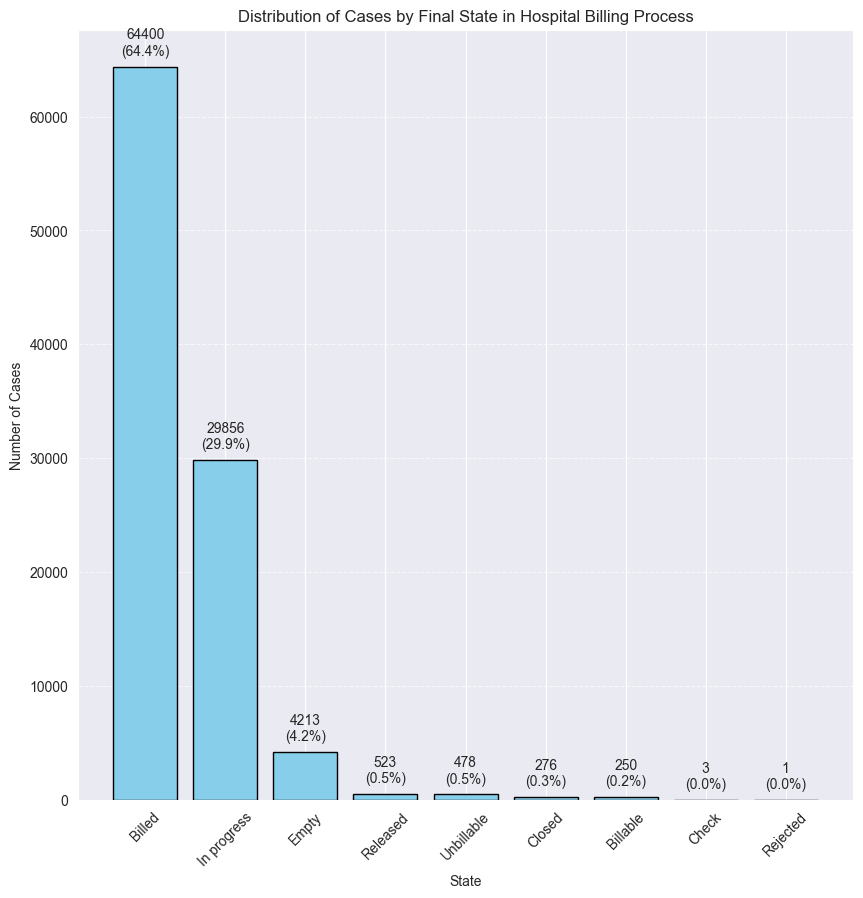

In [21]:
plt.figure(figsize=(10, 10))
plt.bar(ratio_of_state['state'], ratio_of_state['case'], color='skyblue', edgecolor='black')
plt.xlabel('State')
plt.ylabel('Number of Cases')
plt.title('Distribution of Cases by Final State in Hospital Billing Process')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding data labels for both counts and percentages
for index, (value, ratio) in enumerate(zip(ratio_of_state['case'], ratio_of_state['ratio'])):
    plt.text(index, value + 1000, f'{value}\n({ratio:.1%})', ha='center')

plt.show()

### Last event for each case

<Figure size 3200x1600 with 0 Axes>

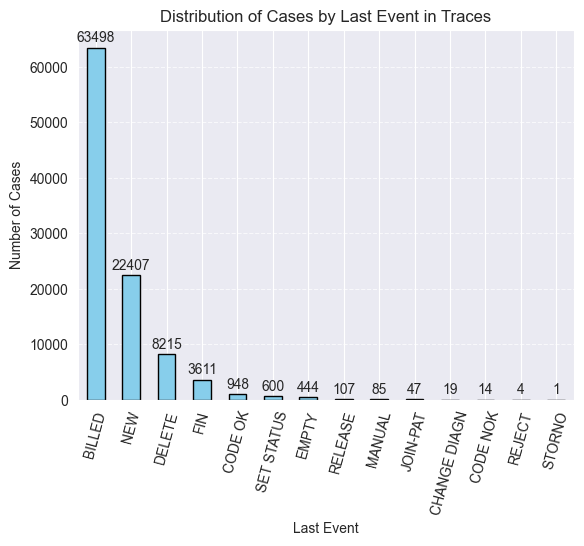

In [26]:
last_event_df = grouped_hospital.groupby(['last_event']).count().sort_values('case',ascending=False)
last_event_df['ratio'] = last_event_df['case'] / last_event_df['case'].sum()
plt.figure(figsize=(32, 16))
last_event_df.reset_index().plot(kind='bar', x='last_event', y='case', color='skyblue', edgecolor='black', legend=False)
plt.title('Distribution of Cases by Last Event in Traces')
plt.xlabel('Last Event')
plt.ylabel('Number of Cases')
plt.xticks(rotation=75)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding data labels for counts
for index, (value, ratio) in enumerate(zip(last_event_df['case'], last_event_df['ratio'])):
    plt.text(index, value + 1000, f'{value}', ha='center', fontsize=10)  # Adjust font size if needed

plt.show()

### Case Type

In [ ]:
case_type = hospital_billing.groupby(['case','caseType'])
case_type.size()


### Gaps or Delays
--> Start time = Complete time

In [ ]:
hospital_billing[hospital_billing['startTime'] != hospital_billing['completeTime']]

### Blocked Cases

In [ ]:
blocked = hospital_billing[hospital_billing['blocked']]
blocked

In [ ]:
hospital_billing['completeTime'] = pd.to_datetime(hospital_billing['completeTime'])
initialisation_time = hospital_billing.groupby(['case']).first().reset_index()

df = initialisation_time.set_index('completeTime')

monthly_counts = df['case'].resample('M').count()

plt.figure(figsize=(12, 6))
monthly_counts.plot(marker='o', linestyle='-')
plt.title('Initialisation of Traces Over Time (Monthly Counts)')
plt.xlabel('Month')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
hospital_billing['completeTime'] = pd.to_datetime(hospital_billing['completeTime'])
finalising_time = hospital_billing.groupby(['case']).last().reset_index()

df = finalising_time.set_index('completeTime')

monthly_counts = df['case'].resample('M').count()

plt.figure(figsize=(12, 6))
monthly_counts.plot(marker='o', linestyle='-')
plt.title('Finalisation of Traces Over Time (Monthly Counts)')
plt.xlabel('Month')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Results of the Output

In [ ]:
import pandas as pd
output_df = pd.read_csv("../Dataset/Hospital Billing Delta Logs/cases_output/cases_output_Hospital Billing - Event Log_weekly_(12).csv")
output_df[(output_df["cancelled"] == False) & (output_df["last_state"]!="Billed") & (output_df["sleep"])]
output_df["delta_counter"]

In [ ]:
output_df["delta_counter"] = output_df["delta_counter"] + 1
output_df["delta_counter"]

In [ ]:
cancelled_cases = output_df[output_df["cancelled"]]

print(f"Number of Cancelled Cases: {len(cancelled_cases)}")

# cancelled_cases["unique_events"].value_counts()

# output_df[output_df["cancelled"]]["unique_events"].value_counts()


In [ ]:
not_cancelled_len = len(output_df)- len(cancelled_cases)
not_cancelled_comp = output_df[(output_df["cancelled"] == False) & (output_df["isComplete"])]

print(not_cancelled_len)
print((not_cancelled_len - len(not_cancelled_comp))/not_cancelled_len)

not_cancelled_comp